# Datathon 2024: Category A (Champions) Workshop

# 1 Preparing data

A model needs data to be trained for predictions. But there are steps needed to ensure that the data is cleaned and ready for a model - if the data is wrongly formatted or missing, the model will not work as intended.

The steps below will help you get started should you be new to the concept.

## 1.1 Preparing Data

To use colab environment, we need to mount Google Drive to Colab. Ensure you have dataset saved in or a shortcut to it created in 'My Drive', on your google drive. Use the cell below to open dataset on Google Colab.

In [1]:
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score

from catboost import CatBoostRegressor

from google.colab import drive

filepath = './data/catA_train.csv'

SEED = 42

In [5]:
df = pd.read_csv(filepath)
print(f'Shape of data: {df.shape}')
df.head()

Shape of data: (29182, 28)


,LATITUDE,LONGITUDE,AccountID,Company,SIC Code,Industry,8-Digit SIC Code,8-Digit SIC Description,Year Found,Entity Type,Parent Company,Parent Country,Ownership Type,Company Description,Square Footage,Company Status (Active/Inactive),Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Fiscal Year End,Global Ultimate Company,Global Ultimate Country,Domestic Ultimate Company,Is Domestic Ultimate,Is Global Ultimate
0,1.285,103.844,LAKB2BID4559214,FRANK CONSULTING SERVICES PRIVATE LIMITED,7361.000,Employment Agencies,73610000.000,Employment agencies,2020.000,Subsidiary,FRANK RECRUITMENT GROUP PRIVATE LTD.,Singapore,Private,Frank Consulting Services Private Limited is p...,NaN,Active,15.000,25.000,NaN,2209224.000,4637871.000,NaN,NaN,FINDERS HOLDCO LIMITED,United Kingdom,FRANK RECRUITMENT GROUP PRIVATE LTD.,0.000,0.000
1,1.291,103.827,LAKB2BID7610849,NEW DESERT ORCHID SHIPPING PTE. LTD.,4449.000,"Water Transportation of Freight, Not Elsewhere...",44490000.000,Water transportation of freight,2015.000,Subsidiary,FORTITUDE SHIPPING PTE. LTD.,Singapore,Private,New Desert Orchid Shipping Pte. Ltd. is primar...,NaN,Active,39.000,100.000,100.000,7093536000.000,7093536000.000,NaN,NaN,PETREDEC PTE. LIMITED,Singapore,NaN,0.000,0.000
2,1.300,103.858,LAKB2BID5461679,2MBAO BIOCELLBANK PTE. LTD.,6719.000,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.000,"Holding companies, nec",1993.000,Subsidiary,MADISON LIGHTERS AND WATCHES CO LTD,Hong Kong SAR,Private,2Mbao Biocellbank Pte. Ltd. is primarily engag...,NaN,Active,4.000,4.000,4.000,1026308.000,1026308.000,NaN,NaN,MADISON LIGHTERS AND WATCHES CO LTD,Hong Kong SAR,2MBAO BIOCELLBANK PTE. LTD.,1.000,0.000
3,1.301,103.791,LAKB2BID5088529,NEWBLOOM PTE. LTD.,6719.000,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.000,"Holding companies, nec",2006.000,Subsidiary,WILMAR INTERNATIONAL LIMITED,Singapore,Private,Newbloom Pte. Ltd. is primarily engaged in hol...,NaN,Active,10.000,100.000,100.000,73398976000.000,73398976000.000,NaN,NaN,WILMAR INTERNATIONAL LIMITED,Singapore,WILMAR INTERNATIONAL LIMITED,0.000,0.000
4,1.299,103.859,LAKB2BID1268831,ASIA GREEN CAPITAL PTE. LTD.,6719.000,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.000,"Holding companies, nec",2006.000,Parent,ASIA GREEN CAPITAL PTE. LTD.,Singapore,Private,Asia Green Capital Pte. Ltd. is primarily enga...,NaN,Active,NaN,4.000,4.000,432213.000,432213.000,Exports,NaN,ASIA GREEN CAPITAL PTE. LTD.,Singapore,ASIA GREEN CAPITAL PTE. LTD.,1.000,1.000


In [6]:
# Show information better than describe() and info()
desc = pd.DataFrame(index=df.columns)
desc["count"] = df.count()
desc["null"] = df.isna().sum()
desc["%null"] = desc["null"] / len(df) * 100
desc["nunique"] = df.nunique()
desc["%unique"] = desc["nunique"] / len(df) * 100
desc["type"] = df.dtypes
desc = pd.concat([desc, df.describe().T.drop("count", axis=1)], axis=1)

# styles = [dict(selector=f".row_heading", props=[('text-align', 'left')])]
# desc = desc.style.set_table_styles(styles)
desc

,count,null,%null,nunique,%unique,type,mean,std,min,25%,50%,75%,max
LATITUDE,29062,120,0.411,9305,31.886,float64,1.321,0.044,1.239,1.285,1.310,1.338,1.470
LONGITUDE,29062,120,0.411,9307,31.893,float64,103.843,0.054,103.611,103.832,103.849,103.866,104.003
AccountID,29182,0,0.000,29182,100.000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Company,29182,0,0.000,29182,100.000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIC Code,29182,0,0.000,582,1.994,float64,6169.271,1705.846,132.000,5084.000,6719.000,7311.000,9721.000
Industry,29182,0,0.000,580,1.988,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8-Digit SIC Code,29182,0,0.000,2255,7.727,float64,61690923.550,17057775.477,1320000.000,50840000.000,67190000.000,73110000.000,97219905.000
8-Digit SIC Description,29182,0,0.000,2191,7.508,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year Found,28748,434,1.487,106,0.363,float64,2004.506,13.464,1819.000,1997.000,2008.000,2014.000,2023.000
Entity Type,29182,0,0.000,4,0.014,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## RF

In [7]:
df_tmp = df.drop(["Square Footage", "Import/Export Status", "Fiscal Year End"], axis=1)
df_tmp = df_tmp.dropna()
df_tmp = df_tmp.select_dtypes(include=np.number)

X = df_tmp.drop("Sales (Domestic Ultimate Total USD)", axis=1)
y = df_tmp["Sales (Domestic Ultimate Total USD)"]

cat_features = list(X.select_dtypes(include=["category", "object"]).columns)
print(cat_features)

cat = CatBoostRegressor(cat_features=cat_features, verbose=0)

cat.fit(X, y)

[]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
cat = CatBoostRegressor(cat_features=cat_features, verbose=0)

cat.fit(X_train, y_train)

In [9]:
r2_score(y_test, cat.predict(X_test))
# r2_score(y_train, cat.predict(X_train))

0.3056087973270376

In [10]:
from sklearn.ensemble import RandomForestRegressor

df_tmp = df.drop(["Square Footage", "Import/Export Status", "Fiscal Year End"], axis=1)
df_tmp = df_tmp.dropna()
df_tmp = df_tmp.select_dtypes(include=np.number)

X = df_tmp.drop("Sales (Domestic Ultimate Total USD)", axis=1)
y = df_tmp["Sales (Domestic Ultimate Total USD)"]
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

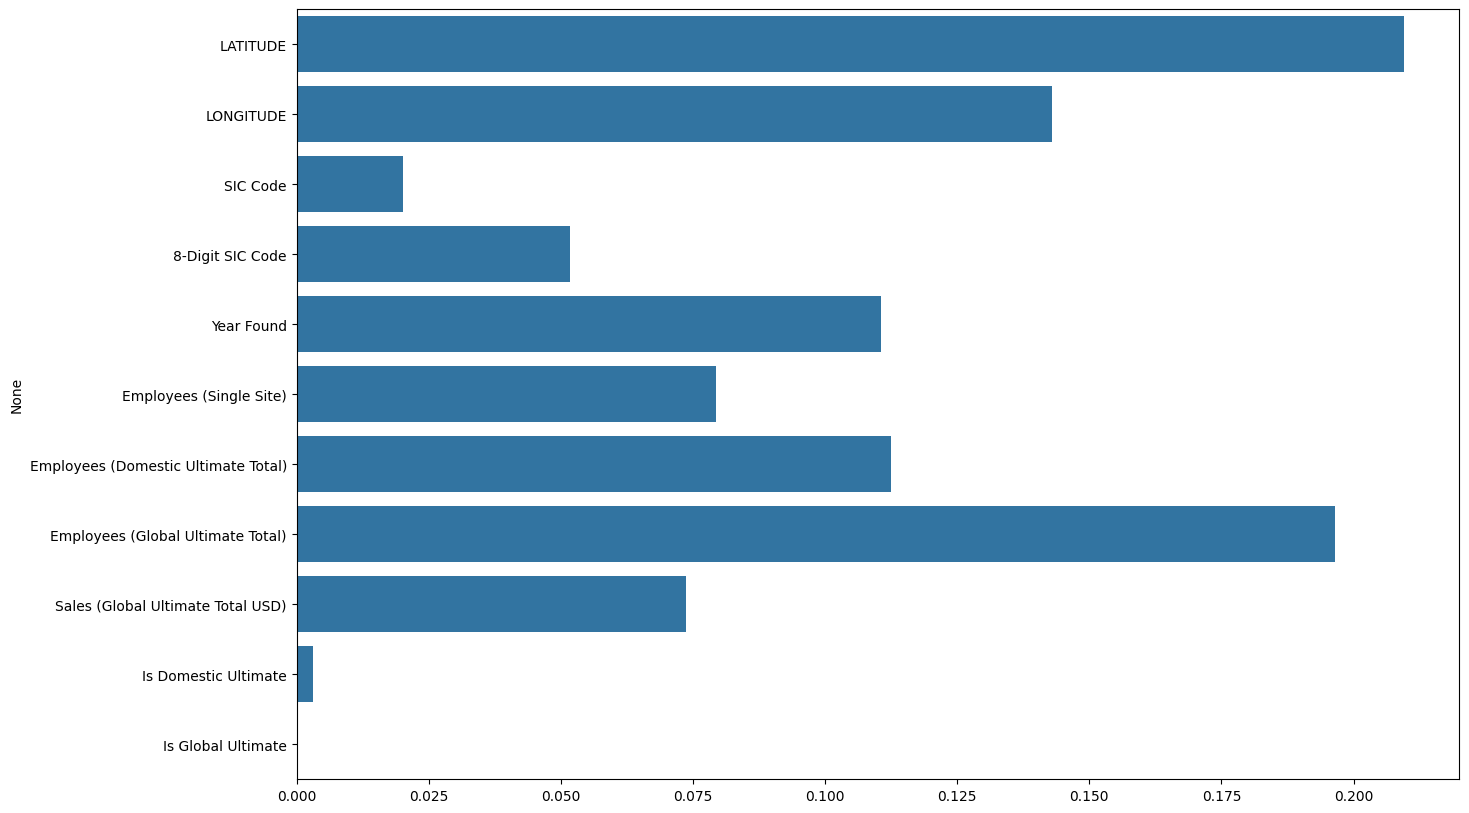

In [11]:
# prompt: plot feature importance of rf
plt.figure(figsize=(15, 10))
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.show()

## 1.2 Processing Data


#### Drop NaN Values
- We choose to drop rows without latitude and longitude coordinates as they only form a very small part of our dataset.

#### One-Hot Encoding
We will also handle categorical variables by performing one-hot encoding on all columns with important categories as values. This is done by using the pd.get_dummies function.

An alternative approach using the LabelEncoder from scikit-learn is also demonstrated.

- Be cautious about the Curse of Dimensionality!

In [12]:
# Remove rows where the Company Status is 'Inactive'
df = df[df['Company Status (Active/Inactive)'] == 'Active']

In [13]:
# to ensure important info isnt being lost
df['Import/Export Status_Missing'] = df['Import/Export Status'].isna()

df3 = df.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)",
                                       "Year Found"])

df3 = pd.get_dummies(df3, columns=['Entity Type'], prefix='Entity_Type')
df3 = pd.get_dummies(df3, columns=['Ownership Type'], prefix='Ownership_Type')
df3 = pd.get_dummies(df3, columns=['Import/Export Status'], prefix='Import_Export_Status')
df3 = df3.drop(columns=[col for col in ["Company Status (Active/Inactive)", "Entity Type", 'Import/Export Status', 'Ownership Type'] if col in df3.columns], errors='ignore') # are all Active]




In [14]:
# Check the number of null values
df3.isna().sum()

LATITUDE                                          62
LONGITUDE                                         62
AccountID                                          0
Company                                            0
SIC Code                                           0
Industry                                           0
8-Digit SIC Code                                   0
8-Digit SIC Description                            0
Year Found                                         0
Parent Company                                   229
Parent Country                                   229
Company Description                                0
Square Footage                                 14373
Employees (Single Site)                            0
Employees (Domestic Ultimate Total)                0
Employees (Global Ultimate Total)                  0
Sales (Domestic Ultimate Total USD)                0
Sales (Global Ultimate Total USD)                  0
Fiscal Year End                               

In [15]:
# Find the frequency of each industry
sic_code_frequency = df3['SIC Code'].value_counts()

# Set a threshold for low-frequency SIC Codes
threshold = 7  # Adjust this threshold based on your preference

# Identify SIC Codes with frequency below the threshold
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index

# Replace these low-frequency SIC Codes with a common label "Others"
df3['SIC Code'] = df3['SIC Code'].replace(low_frequency_sic_codes, 'Others')

sic_code_frequency1 = df3['SIC Code'].value_counts()

# Display the updated DataFrame
print(sic_code_frequency1)

6719.0    2786
Others     833
8742.0     650
7389.0     450
4731.0     434
          ... 
7832.0       7
3448.0       7
2813.0       7
5963.0       7
7549.0       7
Name: SIC Code, Length: 244, dtype: int64


In [16]:
# convert to str cus we dont want it to be trained as a numeric value
# Convert the entire column to a common data type (string in this case)
df3['SIC Code'] = df3['SIC Code'].astype(str)

The alternative approach to encoding is indicated below to deal with SIC Codes.

For more information on SIC Codes, visit the site here: https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
# Use label encoding for 'SIC Code'
label_encoder = LabelEncoder()
df3['SIC Code'] = label_encoder.fit_transform(df3['SIC Code'])

In [19]:
df3["SIC Code"].unique()

array([ 67, 174, 243,  16, 176, 201, 204,  75,   3, 173,  63, 103, 180,
       112, 146,  33, 129, 228,  99,  58,  70,  84, 237, 124, 105, 172,
       171,  62, 116, 104, 145, 168,  65, 193,  89, 196, 150,  77,  74,
       184, 232, 181, 130, 240,  39, 207, 167, 192,  83, 131,  34, 120,
       238,  81, 189, 206,  92, 226, 199,  49, 157, 133,  15, 163, 195,
       186,  54,   5, 175, 169, 197, 100, 236,  96, 155, 106, 212, 152,
       208, 222,  43, 113, 233, 144, 241,  18, 213, 107, 148,  46,  91,
       225,  23, 128,   9, 141,  80,  95, 188,  78,  87, 132,  29, 230,
       125, 220, 216, 121,  11, 135, 191, 227, 223,  57, 160, 165,   1,
        60, 140,   6,  47, 239, 170, 123,  73, 134,  82, 221, 137,  97,
       194,  85,  31,  26,  10,  28,   2,  52, 139,  32,  71,  94,  36,
       242, 156,  40, 217,  93,  21, 143, 101,  61, 111, 159, 185,  69,
       234, 214, 147, 179,  79,  17, 151,  59, 119, 149,  98, 108, 215,
        12,  88,  55,  20,  90, 209, 187,  76,  30, 178, 219, 16

# 2. EDA

We will now proceed to analyze and visualize a subset of our data to gain some rough insight into how inputs in our data are related to our outputs.

## 2.1. Plotting Graphs

### Correlation Matrix

We will first use a Correlation Matrix to observe how a variable in the dataset are affected by other variables.

<Axes: >

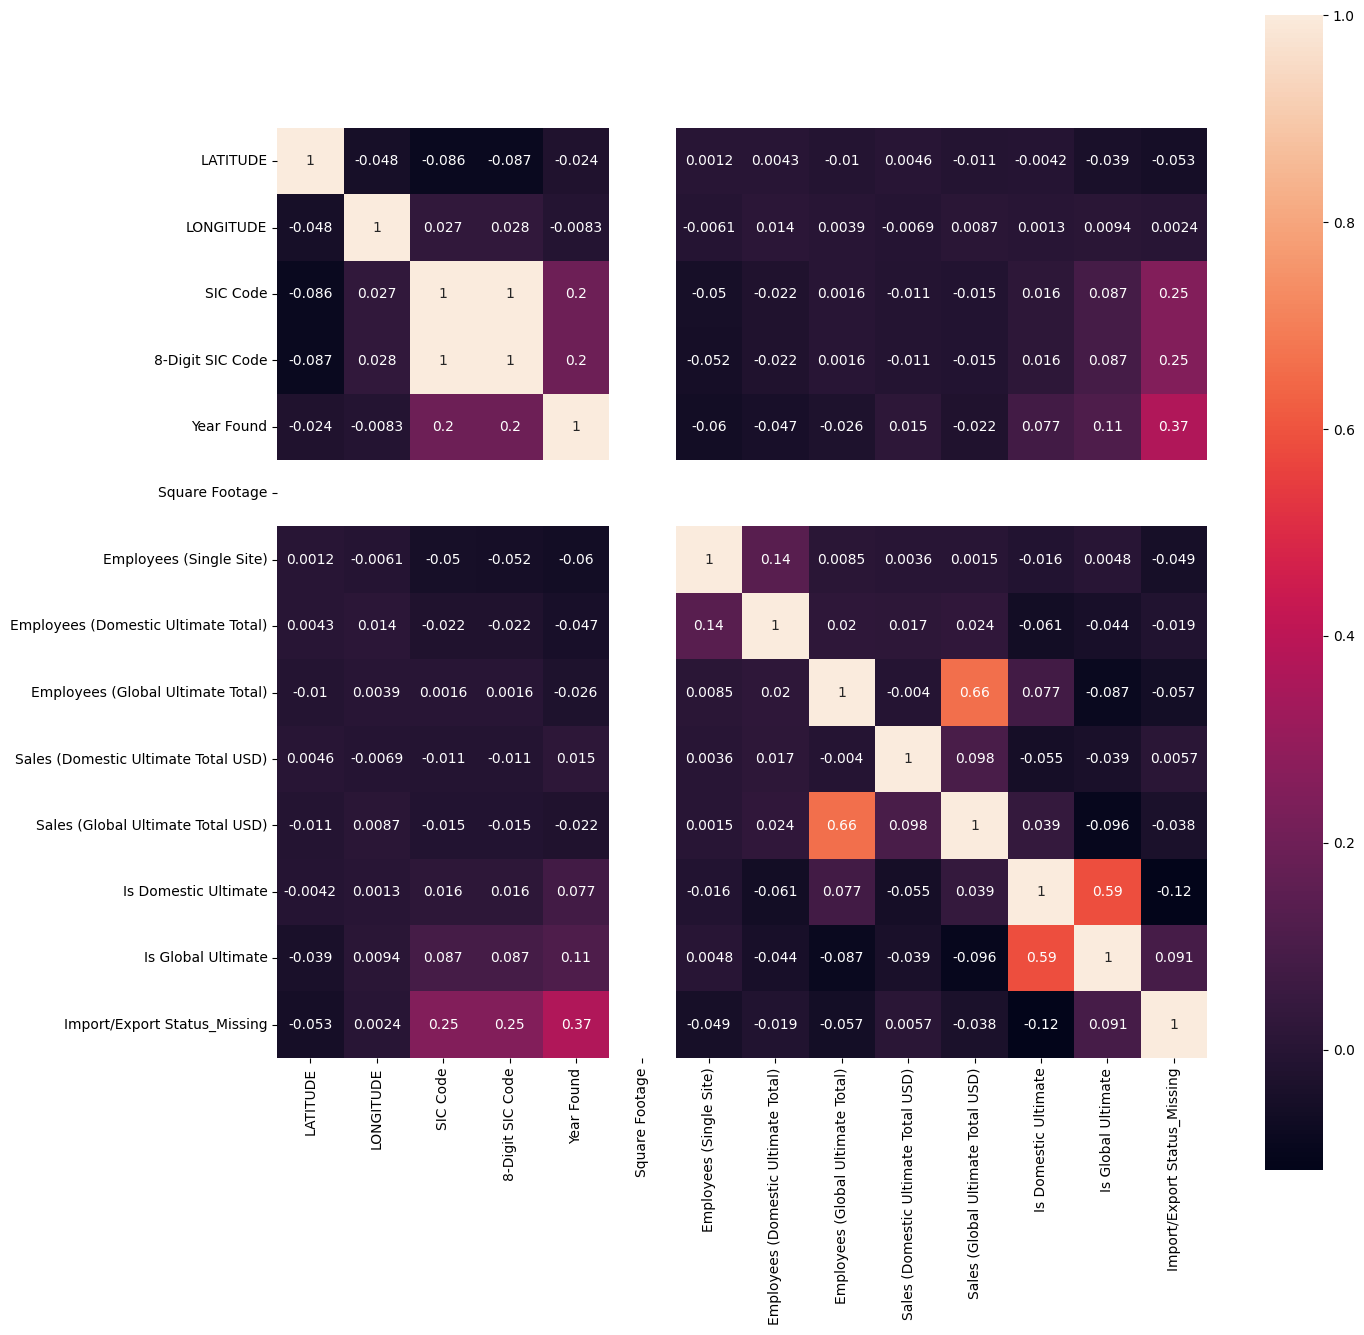

In [20]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(numeric_only=True), square=True, annot=True)

### AccountID
No clear pattern


In [21]:
df["AccountID"]

0        LAKB2BID4559214
1        LAKB2BID7610849
2        LAKB2BID5461679
3        LAKB2BID5088529
4        LAKB2BID1268831
              ...       
29177    LAKB2BID5423564
29178    LAKB2BID6196188
29179    LAKB2BID6100985
29180    LAKB2BID5144338
29181    LAKB2BID6700434
Name: AccountID, Length: 29182, dtype: object

### "Company" features


In [22]:
# Company	Parent Company Company Description Global Ultimate Company Domestic Ultimate Company
df[["Company", "Parent Company", "Company Description", "Global Ultimate Company", "Domestic Ultimate Company"]]
# df.loc[0, "Company Description"]

,Company,Parent Company,Company Description,Global Ultimate Company,Domestic Ultimate Company
0,FRANK CONSULTING SERVICES PRIVATE LIMITED,FRANK RECRUITMENT GROUP PRIVATE LTD.,Frank Consulting Services Private Limited is p...,FINDERS HOLDCO LIMITED,FRANK RECRUITMENT GROUP PRIVATE LTD.
1,NEW DESERT ORCHID SHIPPING PTE. LTD.,FORTITUDE SHIPPING PTE. LTD.,New Desert Orchid Shipping Pte. Ltd. is primar...,PETREDEC PTE. LIMITED,NaN
2,2MBAO BIOCELLBANK PTE. LTD.,MADISON LIGHTERS AND WATCHES CO LTD,2Mbao Biocellbank Pte. Ltd. is primarily engag...,MADISON LIGHTERS AND WATCHES CO LTD,2MBAO BIOCELLBANK PTE. LTD.
3,NEWBLOOM PTE. LTD.,WILMAR INTERNATIONAL LIMITED,Newbloom Pte. Ltd. is primarily engaged in hol...,WILMAR INTERNATIONAL LIMITED,WILMAR INTERNATIONAL LIMITED
4,ASIA GREEN CAPITAL PTE. LTD.,ASIA GREEN CAPITAL PTE. LTD.,Asia Green Capital Pte. Ltd. is primarily enga...,ASIA GREEN CAPITAL PTE. LTD.,ASIA GREEN CAPITAL PTE. LTD.
...,...,...,...,...,...
29177,DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.,SENDA INTERNATIONAL CAPITAL LIMITED,Dystar Global Holdings (Singapore) Pte. Ltd. i...,"Zhejiang Longsheng Group Co., Ltd.",DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.
29178,ORTUS HOLDINGS LTD.,NaN,Ortus Holdings Ltd. is primarily engaged in ho...,NaN,NaN
29179,ABRDN ASIA LIMITED,ABRDN HOLDINGS LIMITED,Abrdn Asia Limited is primarily engaged in iss...,ABRDN HOLDINGS LIMITED,ABRDN ASIA LIMITED
29180,FANSIPAN HOLDINGS PTE. LTD.,ENCYCLIA 1 INVESTMENTS PTE. LTD.,Fansipan Holdings Pte. Ltd. is primarily engag...,65EP INVESTMENT I PTE. LTD.,65EP INVESTMENT I PTE. LTD.


In [23]:
df["Parent Company"].value_counts()

GIC (VENTURES) PTE. LTD.                                 288
RECOSIA PTE LTD                                           66
Cititrust (Switzerland) Limited                           66
FRASERS PROPERTY LIMITED                                  57
HSBC INSTITUTIONAL TRUST SERVICES (SINGAPORE) LIMITED     50
                                                        ... 
World Wrestling Entertainment, Inc.                        1
S & W PTE. LTD.                                            1
BLACK SUN INTERNATIONAL LIMITED                            1
BAUSCH + LOMB IRELAND LIMITED                              1
ENCYCLIA 1 INVESTMENTS PTE. LTD.                           1
Name: Parent Company, Length: 17882, dtype: int64

In [24]:
# Find the frequency of each parent company
par_freq = df["Parent Company"].value_counts()


threshold = 15


low_frequency_par = par_freq[par_freq < threshold].index

df2 = df.copy()

df2["Parent Company"] = df2["Parent Company"].replace(low_frequency_par, 'Others')

df2["Parent Company"].value_counts()

Others                                                   27254
GIC (VENTURES) PTE. LTD.                                   288
RECOSIA PTE LTD                                             66
Cititrust (Switzerland) Limited                             66
FRASERS PROPERTY LIMITED                                    57
WILMAR SHIP HOLDINGS PTE. LTD.                              50
HSBC INSTITUTIONAL TRUST SERVICES (SINGAPORE) LIMITED       50
KEPPEL LAND LIMITED                                         40
DBS TRUSTEE LIMITED                                         40
LIAN BENG GROUP PTE. LTD.                                   31
EUROPE REALTY HOLDINGS PTE LTD                              28
PACC OFFSHORE SERVICES HOLDINGS LTD.                        26
US FUND INVESTMENTS PTE. LTD.                               26
RECOSIA CHINA PTE LTD                                       25
BONVESTS HOLDINGS LIMITED                                   24
THE ASCOTT HOLDINGS LIMITED                            

### Industry

In [27]:
df2 = df.copy()
# Find the frequency of each industry
sic_code_frequency = df2['Industry'].value_counts()

threshold = 10


low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index


df2['Industry'] = df2['Industry'].replace(low_frequency_sic_codes, 'Others')

df2['Industry'].value_counts()

Offices of Holding Companies, Not Elsewhere Classified            7753
Management Consulting Services                                    1389
Others                                                            1272
Computer Programming Services                                      778
Arrangement of Transportation of Freight and Cargo                 737
                                                                  ... 
Radio and Television Broadcasting and Communications Equipment      10
Offices and Clinics of Dentists                                     10
Petroleum Refining                                                  10
Detective, Guard, and Armored Car Services                          10
Individual and Family Social Services                               10
Name: Industry, Length: 280, dtype: int64

<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Industry'>

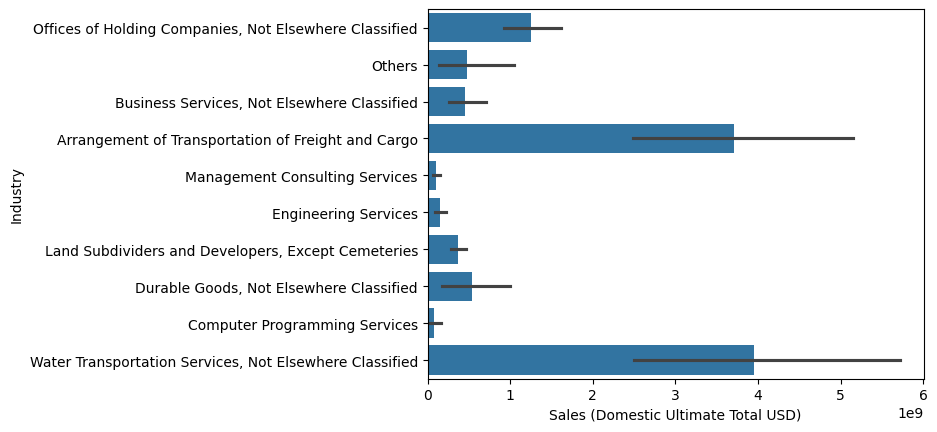

In [28]:
largest_industries = df2["Industry"].value_counts()[:10].index
sns.barplot(data=df2[df2["Industry"].isin(largest_industries)], y="Industry", x="Sales (Domestic Ultimate Total USD)")

### Year Found

No clear pattern


### Entity Type

In [29]:
df["Entity Type"].value_counts()

Subsidiary     20482
Parent          8258
Independent      432
Branch            10
Name: Entity Type, dtype: int64

<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Entity Type'>

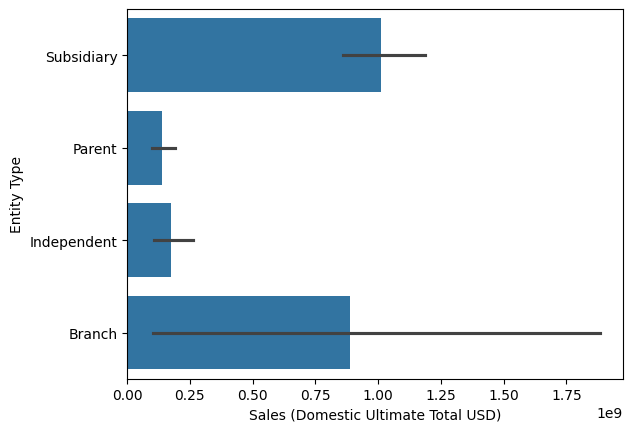

In [30]:
sns.barplot(data=df, y="Entity Type", x="Sales (Domestic Ultimate Total USD)")

### Parent Country and Global Ultimate Country

In [32]:
df2 = df.copy()

pc_frequency = df2['Parent Country'].value_counts()
guc_frequency = df2['Global Ultimate Country'].value_counts()


threshold = 10


low_frequency_pc = pc_frequency[pc_frequency < threshold].index
low_frequency_guc = guc_frequency[guc_frequency < threshold].index


df2['Parent Country'] = df2['Parent Country'].replace(low_frequency_pc, 'Others')
df2['Global Ultimate Countryy'] = df2['Global Ultimate Country'].replace(low_frequency_guc, 'Others')

display(df2['Parent Country'].value_counts())
display(df2['Global Ultimate Country'].value_counts())

Singapore                   21283
Japan                         909
United States                 829
United Kingdom                762
Netherlands                   481
Hong Kong SAR                 470
Germany                       429
India                         377
Switzerland                   368
Malaysia                      300
Australia                     249
France                        235
Virgin Islands (British)      233
China                         189
Cayman Islands                176
Bermuda                       102
Luxembourg                     99
Taiwan                         98
Denmark                        94
Korea, Republic of             89
Norway                         87
Others                         84
Sweden                         84
Italy                          65
Thailand                       59
Ireland                        57
Indonesia                      51
Canada                         51
Austria                        48
Belgium       

Singapore              19234
United States           1590
Japan                   1232
United Kingdom           815
Germany                  536
                       ...  
Croatia                    1
Greece                     1
Antigua and Barbuda        1
Belize                     1
Jamaica                    1
Name: Global Ultimate Country, Length: 74, dtype: int64

### Ownership Type


<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Ownership Type'>

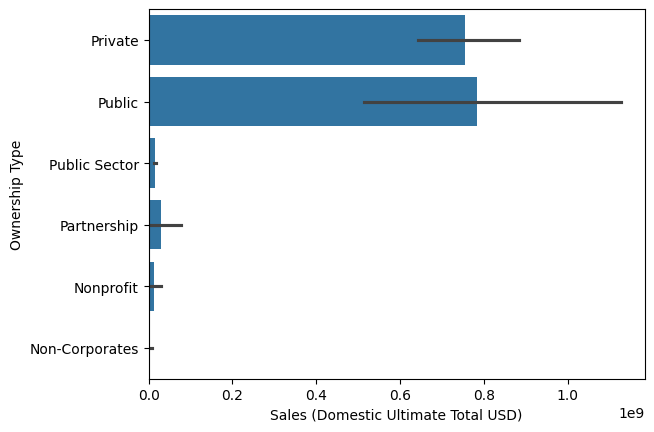

In [33]:
sns.barplot(data=df, y="Ownership Type", x="Sales (Domestic Ultimate Total USD)")

### Employees
No clear pattern

### Sales (Global Ultimate Total USD)

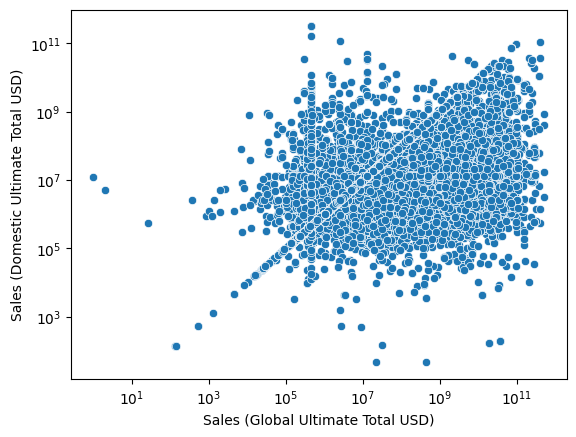

In [34]:

sns.scatterplot(data=df, x="Sales (Global Ultimate Total USD)", y="Sales (Domestic Ultimate Total USD)")
plt.xscale('log')
plt.yscale('log')

### Import/Export Status

In [35]:
df2 = df.copy()
df2.loc[df2["Import/Export Status"].isna(), "Import/Export Status"] = "Missing"
df2["Import/Export Status"].value_counts()

Missing                   22569
Both Imports & Exports     4254
Exports                    1681
Imports                     678
Name: Import/Export Status, dtype: int64

<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Import/Export Status'>

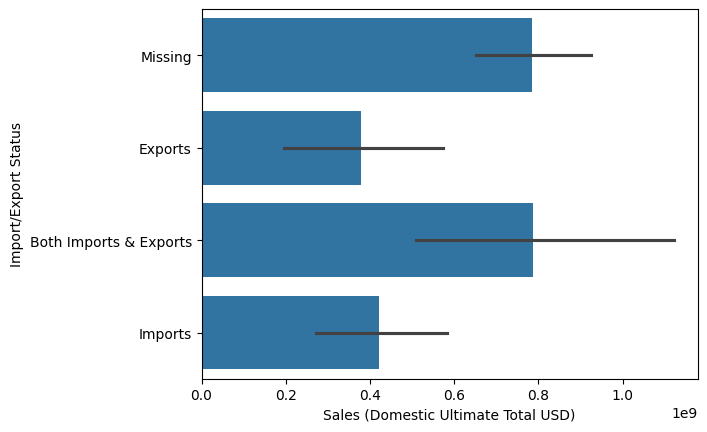

In [36]:
sns.barplot(data=df2, y="Import/Export Status", x="Sales (Domestic Ultimate Total USD)")

### Fiscal Year End


In [37]:
df["Fiscal Year End"].value_counts()

2021-12-31T05:00:00Z    1959
2020-12-31T05:00:00Z     938
2018-12-31T05:00:00Z     580
2022-12-31T05:00:00Z     544
2019-12-31T05:00:00Z     503
                        ... 
2021-11-28T05:00:00Z       1
2022-09-24T04:00:00Z       1
2022-06-24T04:00:00Z       1
2019-12-28T05:00:00Z       1
2022-04-02T04:00:00Z       1
Name: Fiscal Year End, Length: 115, dtype: int64

### Is Domestic Ultimate and Is Global Ultimate

In [38]:
df2 = df.copy()
df2["Is Domestic Ultimate"] = df2["Is Domestic Ultimate"].astype('category')
df2["Is Global Ultimate"] = df2["Is Global Ultimate"].astype('category')
display(df2["Is Domestic Ultimate"].value_counts())
display(df2["Is Global Ultimate"].value_counts())

1.0    14593
0.0    14589
Name: Is Domestic Ultimate, dtype: int64

0.0    21675
1.0     7507
Name: Is Global Ultimate, dtype: int64

<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Is Domestic Ultimate'>

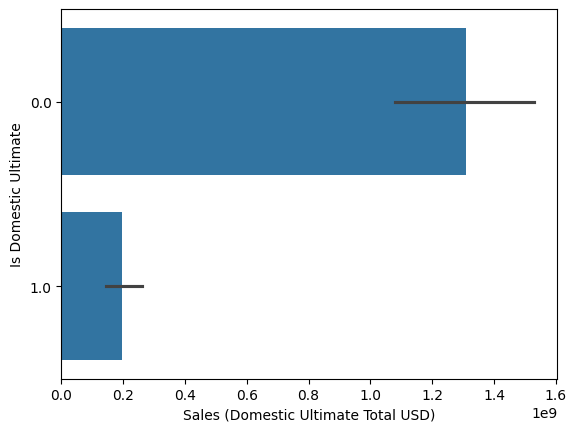

In [39]:
sns.barplot(data=df2, y="Is Domestic Ultimate", x="Sales (Domestic Ultimate Total USD)")

<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Is Global Ultimate'>

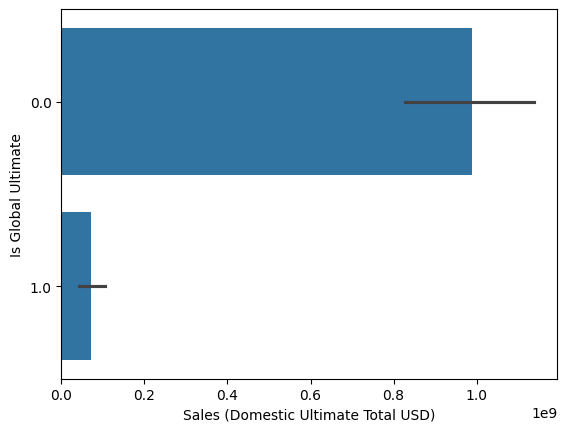

In [40]:
sns.barplot(data=df2, y="Is Global Ultimate", x="Sales (Domestic Ultimate Total USD)")

### Is Ultimate vs Entity Type

<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Entity Type'>

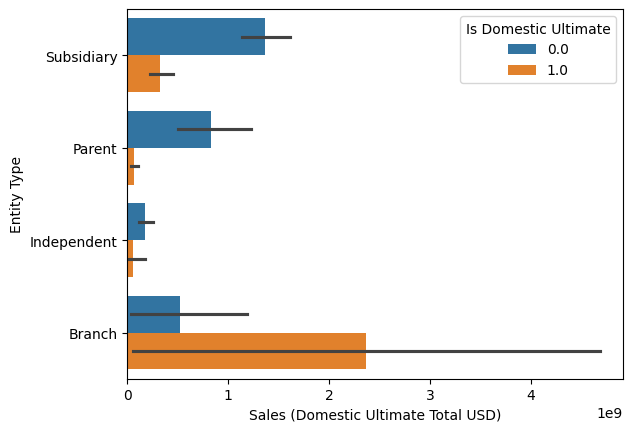

In [41]:
sns.barplot(data=df2, y="Entity Type", x="Sales (Domestic Ultimate Total USD)", hue="Is Domestic Ultimate")

<Axes: xlabel='Sales (Domestic Ultimate Total USD)', ylabel='Entity Type'>

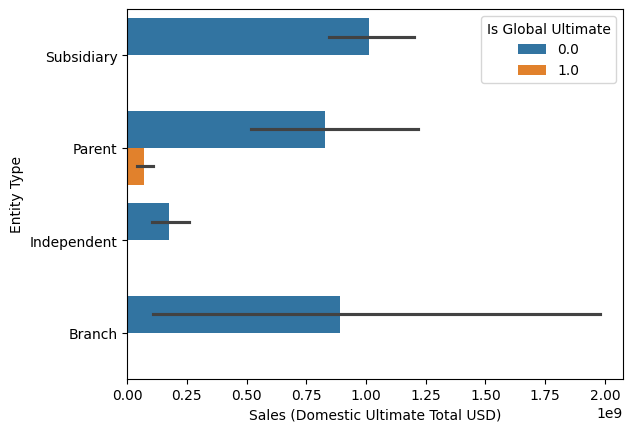

In [42]:
sns.barplot(data=df2, y="Entity Type", x="Sales (Domestic Ultimate Total USD)", hue="Is Global Ultimate")

## 2.2 Feature Selection
We will remove features that are of the following:
- seemingly irrelevant to affecting the output by domain knowledge;
- Low/Zero-variance Factors.

We will also filter our dataset to select only the rows of data we are interested in.

In [43]:
# Specify columns to drop
columns_to_drop = ["error", "Fiscal Year End", "Sales (Global Ultimate Total USD)", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address",
                   "Sales (Global Ultimate Total USD)", "Square Footage", "Company Description", "PostCode", "8-Digit SIC Code", "8-Digit SIC Description", "AccountID",
                   "Parent Company", "City", "Country", "Address", "Address1", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company"]

# Drop columns if they exist in the DataFrame
df4 = df3.drop(columns=[col for col in columns_to_drop if col in df3.columns], errors='ignore')

In [44]:
df4 = df4.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)",
                                       "Year Found"])

### Data Type Conversion

We will need to convert some columns into datatypes that are suitable for analysis. This makes sure that the values in these fields make sense.

In [45]:
# Convert 'Is Domestic Ultimate' to True/False
df4['Is Domestic Ultimate'] = df4['Is Domestic Ultimate'] == 1
df4['Is Global Ultimate'] = df4['Is Global Ultimate'] == 1

In [46]:
df4.columns

Index(['LATITUDE', 'LONGITUDE', 'SIC Code', 'Year Found',
       'Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)', 'Is Domestic Ultimate',
       'Is Global Ultimate', 'Import/Export Status_Missing',
       'Entity_Type_Branch', 'Entity_Type_Independent', 'Entity_Type_Parent',
       'Entity_Type_Subsidiary', 'Ownership_Type_Non-Corporates',
       'Ownership_Type_Nonprofit', 'Ownership_Type_Partnership',
       'Ownership_Type_Private', 'Ownership_Type_Public',
       'Ownership_Type_Public Sector',
       'Import_Export_Status_Both Imports & Exports',
       'Import_Export_Status_Exports', 'Import_Export_Status_Imports'],
      dtype='object')

### 2.3. Preprocessing

In [47]:
def clean(df):
  chosen_cols = [
    "LATITUDE",
    "LONGITUDE",
    # "Industry",
    "Entity Type",
    # "Parent Country",
    # "Global Ultimate Country",
    "Ownership Type",
    "Import/Export Status",
    "Is Domestic Ultimate",
    "Is Global Ultimate",
  ]

  df = df.copy()
  df = df[chosen_cols]

  df.loc[df["Import/Export Status"].isna(), "Import/Export Status"] = "Missing"

  df = df.dropna()

  return df

In [48]:
def preprocess(df):
  df = df.copy()
  df = pd.get_dummies(df, columns=['Entity Type'], prefix='EntityType')
  df = pd.get_dummies(df, columns=['Ownership Type'], prefix='OwnershipType')
  df = pd.get_dummies(df, columns=['Import/Export Status'], prefix='ImportExport')
  return df

In [49]:
df_processed = clean(df)
print(df_processed.shape)
df_processed.head()

(29062, 7)


,LATITUDE,LONGITUDE,Entity Type,Ownership Type,Import/Export Status,Is Domestic Ultimate,Is Global Ultimate
0,1.285,103.844,Subsidiary,Private,Missing,0.000,0.000
1,1.291,103.827,Subsidiary,Private,Missing,0.000,0.000
2,1.300,103.858,Subsidiary,Private,Missing,1.000,0.000
3,1.301,103.791,Subsidiary,Private,Missing,0.000,0.000
4,1.299,103.859,Parent,Private,Exports,1.000,1.000


## 3. Modelling

In [50]:
X = clean(df)
y = df.loc[X.index, "Sales (Domestic Ultimate Total USD)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [51]:
# def cv_score(model, report_mean=True):
#     FOLDS = 8
#     kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

#     scores = []
#     for fold, (train, test) in enumerate(kf.split(X, y)):
#         X_train, X_test = X.iloc[train], X.iloc[test]
#         y_train, y_test = y.iloc[train], y.iloc[test]

#         y_pred = model.fit(X_train, y_train).predict_proba(X_test)
#         scores.append(balanced_log_loss(y_test, y_pred))
#     if report_mean:
#         print(f"CV: {np.mean(scores):.4f} ({np.std(scores):.4f})")
#     else:
#         return scores

def cv_score(model, preprocess):
  FOLDS = 5
  print(X_train.shape, y_train.shape)
  X_processed = preprocess(X_train)
  scores = cross_val_score(model, X_processed, y_train, cv=FOLDS, scoring='r2')
  print(f"CV: {np.mean(scores):.4f} ({np.std(scores):.4f})")

In [52]:
rf = RandomForestRegressor()
cv_score(rf, preprocess)

(23249, 7) (23249,)
CV: -0.1438 (0.1331)


In [54]:
cat_features = list(X_train.select_dtypes(include=["category", "object"]).columns)
print(cat_features)

cat = CatBoostRegressor(cat_features=cat_features, verbose=0)

cat.fit(X_train, y_train)

['Entity Type', 'Ownership Type', 'Import/Export Status']


In [55]:
# r2_score(y_train, cat.predict(X_train))
r2_score(y_test, cat.predict(X_test))

-0.08522395828049567

# 3 Model Training and Evaluation

## 3.1 Selecting a Model
Selecting a model involves a couple of decisions to make:

- Train-test Split: the proportion of data used to train, test and evaluate our data,
- Type of ML model used (well-known ones include Decision Trees, Random Forests, Support Vector Machines, Linear/Logistic Regression and Neural Networks).

In our case, we will use the Gradient Boosting Regressor provisioned by scikit-learn.

In [56]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

In [57]:
# Separate features and target variable
X = df4.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df4['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

# Saving and testing the model



In [62]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform.

All relevant code MUST be included in this function.'''

    predictions = cat.predict(hidden_data)
    return predictions

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

Feel free to explore the functions as written above and play around with more models! You may be able to achieve a higher accuracy.

Happy learning and coding!